# Shearlexity: shearlet-based spatial entropy  and complexity maps for textures

## Installation

1. Install Anaconda Python distribution
3. Install additional dependensies with `conda`:
```bash
conda install scipy matplotlib jupyter
```
3. Install `PyShearlets` library with `pip`:
```bash
pip install https://github.com/grlee77/PyShearlets/archive/master.zip
```

## Demo

Open the shearlexity-demo.ipynb with `jupyter notebook`

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc("image",cmap='gray', aspect='equal',interpolation='nearest')

In [3]:
from numba import jit

In [4]:
from FFST import shearletTransformSpect

/home/brazhe/opt/anaconda3/envs/shearlexity/lib/python3.6/site-packages/FFST/_fft.py:52: UserWarning: pyFFTW not found.  will try to use mklfft instead.
  warnings.warn("pyFFTW not found.  will try to use mklfft instead.")
/home/brazhe/opt/anaconda3/envs/shearlexity/lib/python3.6/site-packages/FFST/_fft.py:64: UserWarning: neither pyFFTW or mklfft found.  will use numpy.fft.
  warnings.warn("neither pyFFTW or mklfft found.  will use numpy.fft.")


In [5]:
import shearlexity

## Adding noise to regular grid

In [6]:
@jit
def corrupt_ppixels(img,p=0.1):
    nrows,ncols = img.shape
    Npx = nrows*ncols
    Ncorrupt = int(round(Npx*p))
    #rr = uniform(nrows,size=Ncorrupt).astype(int)
    #cc = uniform(ncols,size=Ncorrupt).astype(int)
    imgc = img.copy()
    for r in range(nrows):
        for c in range(ncols):
            if uniform() < p:
                imgc[r,c] = uniform()
    return imgc

In [7]:
@jit
def make_grid_pattern(size=512,freq=0.05,incl=0.5):
    sh = size,size
    out = np.zeros(sh)
    for r in range(size):
        for c in range(size):
            out[r,c] = sin(2*pi*(incl*freq*c + (1-incl)*freq*r))
    return out

In [8]:
pjitter = linspace(0,1,51)

%time cxx = [corrupt_ppixels(make_grid_pattern(512, 0.09),p) for p in pjitter]
%time _,psi_stripes = shearletTransformSpect(cxx[0])

CPU times: user 12.5 s, sys: 19.3 ms, total: 12.6 s
Wall time: 12.6 s
CPU times: user 4.07 s, sys: 700 ms, total: 4.77 s
Wall time: 4.77 s


### Here are the corrupted images:

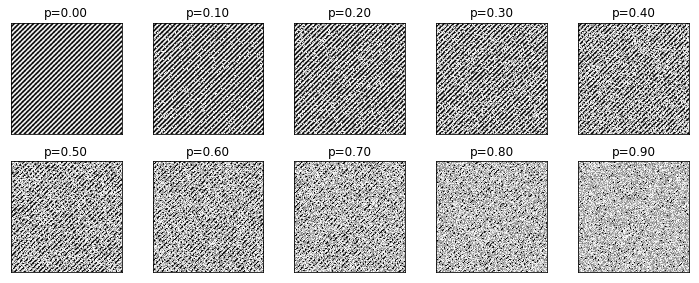

In [9]:
f,axs = subplots(2,5,figsize=(10,4))
for ax, img,p in zip(ravel(axs),cxx[::5],pjitter[::5]):
    ax.imshow(img)
    setp(ax, xticks=[],yticks=[],title='p=%0.2f'%p)
tight_layout()

### Calculate global estimates

In [10]:
%%time 
stripes_g = array([shearlexity.global_cecp(shearletTransformSpect(img,Psi=psi_stripes)[0]) for img in cxx])

CPU times: user 36.5 s, sys: 19 s, total: 55.6 s
Wall time: 55.6 s


### Calculate 'mean fields' of local estimates

In [11]:
sl = (slice(50,-50),slice(50,-50)) # not including possible edge effects

In [12]:
%%time

get_means = lambda l: [le[sl].mean() for le in l]
stripes_mf = array([get_means(shearlexity.local_cecp(img,Psi=psi_stripes)) for img in cxx])

CPU times: user 1min 43s, sys: 27.4 s, total: 2min 11s
Wall time: 2min 11s


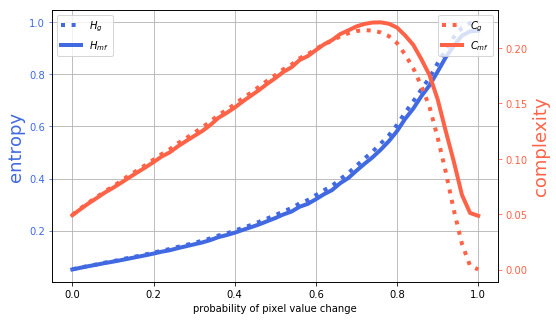

In [13]:
f,ax1 = subplots(1,1,sharex=True,figsize=(8,5))
ax2 = twinx(ax1)
c1 = 'royalblue'
c2 = 'tomato'
kw=dict(mec='none',lw=4,ms=7)

axs = (ax1,ax2)
ax1.tick_params('y', colors=c1)
ax1.plot(pjitter, stripes_g[:,0],':',c=c1,label='global',**kw)
ax1.plot(pjitter, stripes_mf[:,0],'-',c=c1,label='MF',**kw)
ax1.set_ylabel('entropy',color=c1,size=18)

ax2.tick_params('y', colors=c2)
ax2.plot(pjitter, stripes_g[:,1],':',c=c2,label='global',**kw)
ax2.plot(pjitter, stripes_mf[:,1],'-',c=c2,label='MF',**kw)
ax2.set_ylabel('complexity',color=c2,size=18)
ax1.grid(True)
ax1.set_xlabel('probability of pixel value change')
ax1.legend(('$H_g$','$H_{mf}$'))
ax2.legend(('$C_g$','$C_{mf}$'))

Mapped onto the CECP plane, the mean-field values for input images form the complexity-entropy spectrum

Text(0.5,0,'deface probability')

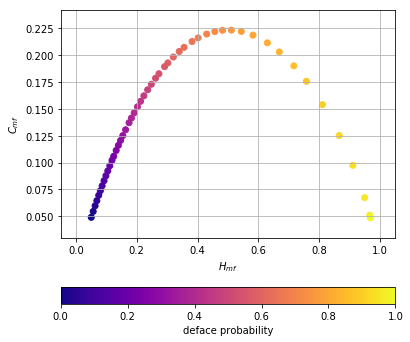

In [14]:
f = figure(figsize=(6,6))
scatter(stripes_mf[:,0],stripes_mf[:,1],c=pjitter,label='mean field',cmap=cm.plasma);
colorbar(orientation='horizontal')
grid(True)
xlim(-0.05,1.05)
xlabel('$H_{mf}$'); ylabel('$C_{mf}$')
f.axes[1].set_xlabel('deface probability')

## Ising surface

In this experiment we use Monte-Carlo simulations of the Ising model with an inhomogeneous temperature spatial profile. Here the lattice is at a temperature below the critical one, but there is a disk of $T=T_c$ in the center of the lattice.

In [15]:
import isingmc

In [16]:
_,psi256 = shearletTransformSpect(randn(256,256))

_,psi512 = shearletTransformSpect(randn(512,512))

psi_sizes = {256:psi256, 512:psi512}

In [17]:
def gauss2d(xmu=0, ymu=0, xsigma=10, ysigma=10):
    return lambda x,y: np.exp(-(x-xmu)**2/(2*xsigma**2) - (y-ymu)**2/(2*ysigma**2))

Text(0.5,1,'Temperature profile')

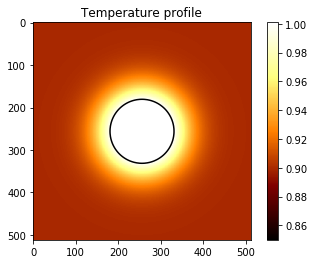

In [18]:
N = 512

fn = gauss2d(N/2,N/2, N//8,N//8)

Tr_profile = clip(0.9 + 0.2*fn(*mgrid[:N,:N]),0,1.001)

imshow(Tr_profile,cmap=cm.afmhot,vmin=0.85)
colorbar()
contour(Tr_profile,[1.])
title("Temperature profile")

In [19]:
# It can take a long time to run MC simulation. A cached surface is provided.
# Move the corresponding file to some other name to start the MC simulation anew
saved_surf_name = 'inhomogeneous_ising.npy'

In [20]:
import os

In [21]:
if os.path.exists(saved_surf_name):
    print('Loading cached Ising surface')
    img = np.load(saved_surf_name)
else:
    print('MC simulation in progress...')
    %time img = isingmc.ising_surf(Tr_profile, shape=(N,N), burnin=3e4,niters=2e4)
    np.save(saved_surf_name,img.astype(float32))

Loading cached Ising surface


In [22]:
img = img if img.max()>=0 else -img

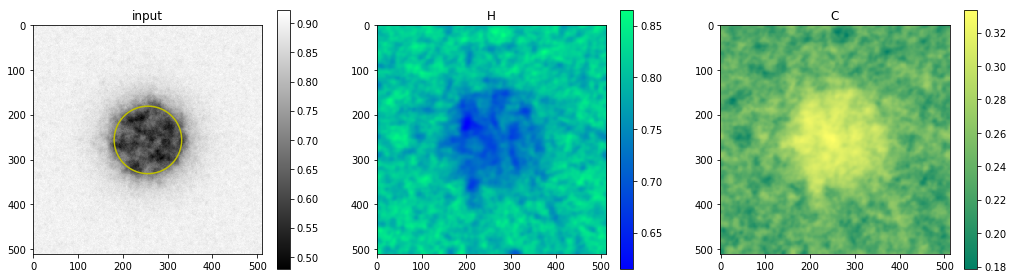

In [23]:
h,c = shearlexity.map_cecp(img,3,Psi=psi512)
f = gcf()
ax = f.axes[0]
ax.contour(Tr_profile,[1.],colors=['y'],)
